In [1]:
from jax.config import config
config.update("jax_enable_x64", True)

import jax.numpy as jnp
from jax import jit, lax, vmap, jacobian
import jax.scipy.linalg as jsl

import jax

import numpy as np
from read_traj_v2 import *

import scipy.optimize
from tqdm import trange
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
mol = 'heh+'
basis = 'sto-3g'
init = 'hf'
td = 'rt-tdexx'

dt = 0.08268/10

inpath = './correctdata'
inpath2 = './mydata/'
outpath = './'
saved_model_dir = './models/'

trnfrq = jnp.array(np.load('./tdcis_data/tdcis_trnfreq_dt0.008268.npz'))
trnamp = jnp.array(np.load('./tdcis_data/tdcis_trnamp_dt0.008268.npz'))
trntme = jnp.array(np.load('./tdcis_data/tdcis_trntme_dt0.008268.npz'))
# load important static matrices
a = traj_data(inpath, mol, basis, init, td, '001',
                init_cond_file=f'ke+en+overlap+ee_twoe+dip_casscf22_{mol}_{basis}.npz',
                )
a.assign_init_data()
drc = a.drc
xmat, didat, kinmat, enmat = a.xmat, a.didat, a.kinmat, a.enmat
X = xmat


	reading from "./correctdata/ke+en+overlap+ee_twoe+dip_casscf22_heh+_sto-3g.npz"

can only concatenate str (not "NoneType") to str
True is not in list


In [3]:
trnden = jnp.array(np.load('./tdcis_data/tdcis_dt0.0082680.npz'))
#trnden = jnp.array(np.load('./tdhf_data/rt-tdhf_forcing_full_finedt.npz'))
print(trnden.shape)

(301, 10000, 2, 2)


In [4]:
# inds = np.array([140, 141, 142, 143, 144, 150, 151, 152, 153,
#        154, 155, 156, 157, 158, 159, 165, 166, 167,168,169])
inds = np.array([145])
trnden = trnden[inds]
trnfrq = trnfrq[inds]
trnamp = trnamp[inds]
trntme = trntme[inds]

In [5]:
print(trnden.shape)

(1, 10000, 2, 2)


In [6]:
# overlapAO = np.array([[1.0, 0.538415], [0.538415, 1.0]])
# s, U = np.linalg.eig(overlapAO)
# dens = np.load('./tdcis_data/td_dens_tdcis_heh+_sto-3g_145_dt=0.082680au.npz')
# dens = dens['td_dens_re_data'] + 1j*dens['td_dens_im_data']

In [7]:
# high_dt = np.diag(np.sqrt(s))  @ U.T @ dens @ U @ np.diag(np.sqrt(s))
# high_dt = high_dt[:10000]

In [8]:
# myinfo(0)

In [9]:
# plt.plot(np.abs(np.fft.fft(trnden[0,:,0,0]))[:])
# plt.plot(np.abs(np.fft.fft(trnden[1,:,0,0]))[:])
# plt.legend(['low_amp', 'high_amp'])

In [10]:
# high_dt = np.diag(np.sqrt(s))  @ U.T @ dens @ U @ np.diag(np.sqrt(s))
# datatotal = high_dt
# acorrs = []
# re00 = datatotal[:,0,0].real
# re01 = datatotal[:,0,1].real
# im01 = datatotal[:,0,1].imag
# re11 = datatotal[:,1,1].real

In [11]:
# data = re11
# # Mean
# mean = np.mean(data)

# # Variance
# var = np.var(data)

# # Normalized data
# ndata = data - mean

In [12]:
# acorr = np.correlate(ndata, ndata, 'full')[len(ndata)-1:] 
# acorr = acorr / var / len(ndata)
# acorrs.append(acorr)

In [13]:
# for j in range(len(acorrs)):
#     plt.plot(acorrs[j])
#     plt.show()
#     plt.close()

In [14]:
# need two masks
# upper mask is matrix whose (u,v)-th element is 0 unless u <= v
# lower mask is matrix whose (u,v)-th element is 0 unless u > v
upper = np.zeros((2,2),dtype=np.float64)
lower = np.zeros((2,2),dtype=np.float64)
for u in range(2):
    for v in range(2):
        if u <= v:
            upper[u,v] = 1.0
        if u > v:
            lower[u,v] = 1.0

ru1 = 2*np.einsum('uv,uk,ma,sb,uvms,vl->klab',upper,X,X,X,a.eeten,X)
ru2 = np.einsum('uv,uk,ma,sb,umvs,vl->klab',upper,X,X,X,a.eeten,X)
rl1 = 2*np.einsum('uv,uk,ma,sb,vums,vl->klab',lower,X,X,X,a.eeten,X)
rl2 = np.einsum('uv,uk,ma,sb,vmus,vl->klab',lower,X,X,X,a.eeten,X)
beta1trueNP = ru1 - ru2 + rl1 - rl2
gamma1trueNP = ru1 - ru2 - rl1 + rl2

beta0trueNP = xmat.conj().T @ (kinmat - enmat) @ xmat
gamma0trueNP = np.zeros(beta0trueNP.shape)

# extract parameters for real target
beta0true = -beta0trueNP.reshape((-1))
beta1true = -beta1trueNP.reshape((drc**2, drc**2))
# extract parameters for imag target
gamma0true = -gamma0trueNP.reshape((-1))
gamma1true = -gamma1trueNP.reshape((drc**2, drc**2))

beta0 = beta0true
# beta1 = beta1true
gamma0 = gamma0true
# gamma1 = gamma1true

thetatrue = jnp.concatenate([beta1true.reshape((-1)), gamma1true.reshape((-1))])

In [36]:
# #nlayers = 2
# #layerwidths = [2*drc**2,164,164,164,2*drc**2]
# nlayers = 2
# layerwidths = [2*drc**2,1200,2*drc**2]
# numparams = 0
# numweights = 0
# for j in range(nlayers):
#     numparams += layerwidths[j]*layerwidths[j+1] + layerwidths[j+1]
#     numweights += layerwidths[j]*layerwidths[j+1]
numparams =  2*11 * drc**4 + 80 + 32 + 8 + 32
# # numparams = 32

In [37]:
def MLham(theta,t,x,y,memory_steps=[],fldfrq=0,fldamp=0,tmeoff=0,norm_direc=0):
    beta1 = thetatrue[:drc**4].reshape((drc**2, drc**2))
    gamma1 = thetatrue[drc**4:2*drc**4].reshape((drc**2, drc**2))
    
#     beta1prev = theta[:drc**4].reshape((drc**2, drc**2))
#     gamma1prev = theta[drc**4:2*drc**4].reshape((drc**2, drc**2))
    
#     beta1prev2= theta[2*drc**4: 3*drc**4].reshape((drc**2,drc**2))
#     gamma1prev2 = theta[3*drc**4:4*drc**4].reshape((drc**2,drc*2))
    
    x = x.reshape((drc**2))
    y = y.reshape((drc**2))
    
    rmat = (beta0 + jnp.matmul(x,beta1))
    qmat = (gamma0 + jnp.matmul(y,gamma1))
     
    if len(memory_steps) > 0:
        final_ind = -1
        for k in range(len(memory_steps)):
            xmk, ymk = memory_steps[k]
            xmk = xmk.reshape((drc**2))
            ymk = ymk.reshape((drc**2))
            # # produce real target
            rmat += ( jnp.matmul(theta[2*k*drc**4:(2*k+1)*drc**4].reshape((drc**2,drc**2)), xmk ))
            # # produce imag target
            qmat += ( jnp.matmul(theta[(2*k+1)*drc**4:(2*k+2)*drc**4].reshape((drc**2,drc**2)), ymk)) 
            final_ind = (2*k+2)*drc**4
        p = x+1j*y
        p2ndorder = jnp.array([p[0]**2, p[0]*p[1], p[0]*p[2], p[0]*p[3],p[1]**2, p[1]*p[2], p[1]*p[3], p[2]**2, p[2]*p[3], p[3]**2])
        invp = (1/(jnp.abs(p) + 1e-3))
        x2 = p2ndorder.real.reshape((10))
        y2 = p2ndorder.imag.reshape((10))

        beta2ndorder = theta[final_ind: final_ind+40].reshape((4,10))
        gamma2ndorder = theta[final_ind+40:final_ind+80].reshape((4,10))
        
        betainv = theta[final_ind+80:final_ind+96].reshape((drc**2,drc**2))
        gammainv = theta[final_ind+96: final_ind+112].reshape((drc**2,drc**2))
        
        betaint = theta[final_ind+112:final_ind+116].reshape((drc**2))
        gammaint = theta[final_ind+116:final_ind+120].reshape((drc**2))
        
        betalin = theta[final_ind+120:final_ind+136].reshape((drc**2,drc**2))
        gammalin = theta[final_ind+136:final_ind+152].reshape((drc**2,drc**2))

        rmat += jnp.matmul(beta2ndorder,x2)
        qmat += jnp.matmul(gamma2ndorder,y2)
        
        rmat += jnp.matmul(betainv,invp.real.reshape(drc**2))
        qmat += jnp.matmul(gammainv, invp.imag.reshape(drc**2))
        
        rmat += betaint
        qmat += gammaint
        
        rmat += jnp.matmul(betalin, x)
        qmat += jnp.matmul(gammalin, y)
        
    rmat = (rmat).reshape((drc,drc))
    qmat = (qmat).reshape((drc, drc))
    h = 0.5*(rmat + rmat.T) + 0.5j*(qmat - qmat.T)
    
    ef = (t>=0)*(t<=tmeoff)*fldamp*jnp.sin(fldfrq*t)
    hfieldAO = ef*jnp.sum(norm_direc[:,None,None]*didat, axis=0, dtype=jnp.complex128)
    h -= xmat.conj().T @ hfieldAO @ xmat
    return h.real, h.imag

In [38]:
mydHdtheta = jacobian(MLham, 0)
dHdXjax = jacobian(MLham, 2)
dHdYjax = jacobian(MLham,3)

In [39]:
m = drc
def expderiv(d, u, w):
    offdiagmask = jnp.ones((m, m)) - jnp.eye(m)
    expspec = jnp.exp(d)
    e1, e2 = jnp.meshgrid(expspec, expspec)
    s1, s2 = jnp.meshgrid(d, d)
    denom = offdiagmask * (s1 - s2) + jnp.eye(m)
    mask = offdiagmask * (e1 - e2)/denom + jnp.diag(expspec)
    prederivamat = jnp.einsum('ij,jk,kl->il',u.conj().T,w,u) 
    derivamat = prederivamat * mask
    return jnp.einsum('ij,jk,kl->il',u,derivamat,u.conj().T)

In [40]:
def expderiv2(d, u, w):
    offdiagmask = jnp.ones((m, m)) - jnp.eye(m)
    expspec = jnp.exp(d)
    e1, e2 = jnp.meshgrid(expspec, expspec)
    s1, s2 = jnp.meshgrid(d, d)
    denom = offdiagmask * (s1 - s2) + jnp.eye(m)
    mask = offdiagmask * (e1 - e2)/denom + jnp.diag(expspec)
    prederivamat = jnp.einsum('ij,abjk,kl->ilab',u.conj().T,w,u) 
    derivamat = jnp.einsum('ilab,il->ilab',prederivamat,mask)
    return jnp.einsum('ij,jkab,kl->ilab',u,derivamat,u.conj().T)

In [41]:
def expderiv3(d, u, w):
    offdiagmask = jnp.ones((m, m)) - jnp.eye(m)
    expspec = jnp.exp(d)
    e1, e2 = jnp.meshgrid(expspec, expspec)
    s1, s2 = jnp.meshgrid(d, d)
    denom = offdiagmask * (s1 - s2) + jnp.eye(m)
    mask = offdiagmask * (e1 - e2)/denom + jnp.diag(expspec)
    prederivamat = jnp.einsum('ij,jka,kl->ila',u.conj().T,w,u) 
    derivamat = jnp.einsum('ila,il->ila',prederivamat,mask)
    return jnp.einsum('ij,jka,kl->ila',u,derivamat,u.conj().T)

In [42]:
def xicomp(theta, x, y, evals, evecs, t, fldfrq,fldamp,tmeoff,norm_direc):
    dHrealdPauto = 0.5*(dHdXjax(theta,t,x,y,fldfrq,fldamp,tmeoff,norm_direc)[0] - 1j*dHdYjax(theta,t,x,y,fldfrq,fldamp,tmeoff,norm_direc)[0])
    dHimagdPauto = 0.5*(dHdXjax(theta,t,x,y,fldfrq,fldamp,tmeoff,norm_direc)[1] - 1j*dHdYjax(theta,t,x,y,fldfrq,fldamp,tmeoff,norm_direc)[1])
    dHdp = dHrealdPauto + 1j*dHimagdPauto
    dHrealdPbarauto = 0.5*(dHdXjax(theta,t,x,y,fldfrq,fldamp,tmeoff,norm_direc)[0] + 1j*dHdYjax(theta,t,x,y,fldfrq,fldamp,tmeoff,norm_direc)[0])
    dHimagdPbarauto = 0.5*(dHdXjax(theta,t,x,y,fldfrq,fldamp,tmeoff,norm_direc)[1] + 1j*dHdYjax(theta,t,x,y,fldfrq,fldamp,tmeoff,norm_direc)[1])
    dHdPbar = dHrealdPbarauto  + 1j*dHimagdPbarauto
    dHdp = dHdp.reshape((drc,drc,drc,drc)).transpose((2,3,0,1))
    dHdPbar = dHdPbar.reshape((drc,drc,drc,drc)).transpose((2,3,0,1))
    jacP = expderiv2(evals, evecs, dHdp)
    jacPbar = expderiv2(evals, evecs, dHdPbar)
    return jacP, jacPbar

def dUdtheta(theta, x, y, evals, evecs, t, fldfrq,fldamp,tmeoff,norm_direc):
    dHdtheta =  mydHdtheta(theta,t, x, y, fldfrq,fldamp,tmeoff,norm_direc)
    tm1 = expderiv3(evals, evecs, dHdtheta[0])
    tm2 = expderiv3(evals, evecs, dHdtheta[1])
    return tm1 + 1j*tm2

In [43]:
mynumsteps = 2000
ntvec = mynumsteps

def MMUT_Adjoint(theta, Ptilde, dt=0.08268, 
                 tmeoff=1, fldfrq=1, fldamp=1, norm_direc=jnp.array([0.0,0.0,1.0])):
    tvec = dt*jnp.arange(ntvec)
    P0 = Ptilde[0,:,:]
    propagated_dens = [P0]
    H0 = MLham(theta,0.0,P0.real,P0.imag,fldfrq,fldamp,tmeoff,norm_direc)
    H0 = H0[0] + 1.0j*H0[1]
    evals, evecs = jnp.linalg.eigh(H0)
    U0 = evecs @ jnp.diag(jnp.exp(-1j*dt*evals)) @ evecs.conj().T
    P1 = U0 @ P0 @ U0.conj().T
    propagated_dens.append( P1 )
    
    def bodyfun(i, dtup):
        dl, dvals, dvecs, dU = dtup
        P0 = dl[i, :, :]
        P1 = dl[i+1, :, :]
        H1 = MLham(theta,(i+1.0)*dt,P1.real,P1.imag,fldfrq,fldamp,tmeoff,norm_direc)
        H1 = H1[0] + 1.0j*H1[1]
        evals, evecs = jnp.linalg.eigh(H1)
        dvals = dvals.at[i+1].set( evals )
        dvecs = dvecs.at[i+1].set( evecs )
        U1 = evecs @ jnp.diag(jnp.exp(-2j*dt*evals)) @ evecs.conj().T
        dU = dU.at[i+1].set( U1 )
        P2 = U1 @ P0 @ U1.conj().T
        dl = dl.at[i+2].set( P2 )
        return (dl, dvals, dvecs, dU)
    
    alldens = jnp.concatenate([jnp.stack(propagated_dens), jnp.zeros((ntvec-1, drc, drc))], axis=0)
    allevals = jnp.concatenate([jnp.expand_dims(evals,0), jnp.zeros((ntvec-1, drc))], axis=0)
    allevecs = jnp.concatenate([jnp.expand_dims(evecs,0), jnp.zeros((ntvec-1, drc, drc))], axis=0)
    allU = jnp.concatenate([jnp.expand_dims(U0,0), jnp.zeros((ntvec-1, drc, drc))], axis=0)
    ftup = lax.fori_loop(0, ntvec-1, bodyfun, (alldens, allevals, allevecs, allU))
    Pstack, allevals, allevecs, allU = ftup

    def bodylamb(i, dl):
        k = ntvec - i
        newlamb = Pstack[k, :, :] - Ptilde[k, :, :]
        xiak = xicomp(theta, Pstack[k].real, Pstack[k].imag,-2j*dt*allevals[k], allevecs[k], i*dt, fldfrq,fldamp,tmeoff,norm_direc)
        xibk = xicomp(theta,  Pstack[k].real.reshape((-1)), Pstack[k].imag.reshape((-1)), 2j*dt*allevals[k], allevecs[k], i*dt, fldfrq,fldamp,tmeoff,norm_direc)
        # if i <---> k correspond, then i-1 <---> k+1 correspond
        newlamb += jnp.einsum('ij,ijkl->kl',dl[i-1] @ allU[k] @ Pstack[k-1], (-2j*dt*xiak[0]).conj())
        newlamb += jnp.einsum('ij,ijkl->kl',dl[i-1] @ allU[k] @ Pstack[k-1], (-2j*dt*xiak[1]).conj()).conj()
        newlamb += jnp.einsum('ij,ijkl->kl',Pstack[k-1] @ allU[k].conj().T @ dl[i-1], (2j*dt*xibk[0]).conj())
        newlamb += jnp.einsum('ij,ijkl->kl',Pstack[k-1] @ allU[k].conj().T @ dl[i-1], (2j*dt*xibk[1]).conj()).conj()
        newlamb += allU[k+1].conj().T @ dl[i-2] @ allU[k+1]
        return dl.at[i].set( newlamb )
    
    lambfinal = Pstack[ntvec, :, :] - Ptilde[ntvec, :, :]
    lambnext = Pstack[ntvec-1, :, :] - Ptilde[ntvec-1, :, :]
    xiak = xicomp(theta, Pstack[ntvec-1].real, Pstack[ntvec-1].imag, -2j*dt*allevals[ntvec-1], allevecs[ntvec-1], (ntvec-1)*dt, fldfrq,fldamp,tmeoff,norm_direc)
    xibk = xicomp(theta, Pstack[ntvec-1].real, Pstack[ntvec-1].imag, 2j*dt*allevals[ntvec-1], allevecs[ntvec-1], (ntvec-1)*dt, fldfrq,fldamp,tmeoff,norm_direc)
    lambnext += jnp.einsum('ij,ijkl->kl',lambfinal @ allU[ntvec-1] @ Pstack[ntvec-2], (-2j*dt*xiak[0]).conj())
    lambnext += jnp.einsum('ij,ijkl->kl',lambfinal @ allU[ntvec-1] @ Pstack[ntvec-2], (-2j*dt*xiak[1]).conj()).conj()
    lambnext += jnp.einsum('ij,ijkl->kl',Pstack[ntvec-2] @ allU[ntvec-1].conj().T @ lambfinal, (2j*dt*xibk[0]).conj())
    lambnext += jnp.einsum('ij,ijkl->kl',Pstack[ntvec-2] @ allU[ntvec-1].conj().T @ lambfinal, (2j*dt*xibk[1]).conj()).conj()
    lambcat = jnp.concatenate([jnp.expand_dims(lambfinal,0), jnp.expand_dims(lambnext, 0), jnp.zeros((ntvec-2, drc, drc))])
    alllamb = lax.fori_loop(2, ntvec, bodylamb, lambcat)
    lambstack = jnp.flipud( jnp.stack(alllamb, axis=0) )    
    
    def bodygrad(k, gL):
        tmp1 = -2j*dt*dUdtheta(theta, Pstack[k].real, Pstack[k].imag, -2j*dt*allevals[k], allevecs[k], k*dt, fldfrq,fldamp,tmeoff,norm_direc)
        term1 = jnp.einsum('ija,jk,kl->ila',tmp1,Pstack[k-1],allU[k].conj().T)
        term2 = term1.transpose((1,0,2)).conj()
        return gL + jnp.real(jnp.einsum('il,ila->a',lambstack[k],(term1+term2).conj()))

    tmp1 = -1j*dt*dUdtheta(theta, Pstack[0].real, Pstack[0].imag, -1j*dt*allevals[0], allevecs[0], 0 , fldfrq,fldamp,tmeoff,norm_direc)
    term1 = jnp.einsum('ija,jk,kl->ila',tmp1,Pstack[0],allU[0].conj().T)
    term2 = term1.transpose((1,0,2)).conj()
    initgradL = jnp.real(jnp.einsum('il,ila->a',lambstack[0],(term1+term2).conj()))
    gradL = lax.fori_loop(1, ntvec, bodygrad, initgradL)
    return gradL/mynumsteps/drc**2
    

In [44]:
def MMUT_Prop_HSB(theta, initial_density, dt=0.08268, ntvec=2000,
                  tmeoff=1, fldfrq=1, fldamp=1, norm_direc=jnp.array([0.0,0.0,1.0])):
    tvec = dt*jnp.arange(ntvec)
    P0 = initial_density.reshape((drc, drc))
    propagated_dens = [P0]
    H0 = MLham(theta,0.0,P0.real, P0.imag,[],fldfrq,fldamp,tmeoff,norm_direc)
    H0 = H0[0] + 1.0j*H0[1]
    evals, evecs = jnp.linalg.eigh(H0)
    U0 = evecs @ jnp.diag(jnp.exp(-1j*dt*evals)) @ evecs.conj().T
    P1 = U0 @ P0 @ U0.conj().T
    propagated_dens.append( P1 )
    def bodyfun(i, dl):
        P0 = dl[i, :, :]
        P1 = dl[i+1, :, :]
        H1 = MLham(theta,(i+1.0)*dt,P1.real, P1.imag,[],fldfrq,fldamp,tmeoff,norm_direc)
        H1 = H1[0] + 1.0j*H1[1]
        evals, evecs = jnp.linalg.eigh(H1)
        U1 = evecs @ jnp.diag(jnp.exp(-2j*dt*evals)) @ evecs.conj().T
        P2 = U1 @ P0 @ U1.conj().T
        return dl.at[i+2].set( P2 )
    alldens = jnp.concatenate([jnp.stack(propagated_dens), jnp.zeros((ntvec-1, drc, drc))], axis=0) 
    fdl = lax.fori_loop(0, ntvec-1, bodyfun, alldens)
    
    return fdl

In [45]:
def preprocess_memory(theta, initial_density, amt_steps, dt=0.08268,
                  tmeoff=1, fldfrq=1, fldamp=1, norm_direc=jnp.array([0.0,0.0,1.0])):
    P0 = initial_density.reshape((drc, drc))
    propagated_dens = [P0]
    H0 = MLham(theta, 0.0, P0.real, P0.imag, [], fldfrq, fldamp, tmeoff, norm_direc)
    H0 = H0[0] + 1.0j*H0[1] 
    evals, evecs = jnp.linalg.eigh(H0)
    U0 = evecs @ jnp.diag(jnp.exp(-1j*dt*evals)) @ evecs.conj().T
    P1 = U0 @ P0 @ U0.conj().T
    propagated_dens.append( P1 )
    for k in range(0,amt_steps-1):
        P0 = propagated_dens[k]
        P1 = propagated_dens[k+1]
        H1 = MLham(theta, (k+1.0)*dt, P1.real, P1.imag, [], fldfrq, fldamp, tmeoff, norm_direc)
        H1 = H1[0] + 1.0j*H1[1] 
        evals, evecs = jnp.linalg.eigh(H1)
        U1 = evecs @ jnp.diag(jnp.exp(-2j*dt*evals)) @ evecs.conj().T
        P2 = U1 @ P0 @ U1.conj().T
        propagated_dens.append( P2 )
    return jnp.array(propagated_dens)

In [46]:
# # unit test to see if manual propagation preprocess code functions the same as previously working propagation code 
# i = 145
# mynumsteps = 500
# ic = trnden[i][0,:,:].reshape((-1))
# testtheta = 0.01 * jnp.array(np.random.normal(size=numparams))
# kernel = preprocess_memory(testtheta, ic, 100, dt=dt, tmeoff=trntme[i], fldfrq=trnfrq[i], fldamp=trnamp[i])
# true_prop  = MMUT_Prop_HSB(testtheta, ic, dt=dt, ntvec=mynumsteps,tmeoff=trntme[i], fldfrq=trnfrq[i], fldamp=trnamp[i])
# np.allclose(kernel,true_prop[:101,:,:],1e-10)

In [47]:
def MMUT_Prop_Memory(theta, initial_density, dt=0.08268, ntvec=2000,
                  tmeoff=1, fldfrq=1, fldamp=1, norm_direc=jnp.array([0.0,0.0,1.0])):
    memory_depth = 100
    propagated_dens = preprocess_memory(theta,initial_density, memory_depth, dt, tmeoff, fldfrq, fldamp ,norm_direc)
    def bodyfun(i, dl):
        P0 = dl[i, :, :]
        P1 = dl[i+1, :, :] 
        memory_kernel = [(dl[i-k, :, :].real, dl[i-k, :, :].imag) for k in range(memory_depth)]
        memory_kernel = memory_kernel[0::10]
        H1 = MLham(theta,(i+1.0)*dt,P1.real, P1.imag,memory_kernel, fldfrq,fldamp,tmeoff,norm_direc)
        H1 = H1[0] + 1.0j*H1[1]
        evals, evecs = jnp.linalg.eigh(H1)
        U1 = evecs @ jnp.diag(jnp.exp(-2j*dt*evals)) @ evecs.conj().T
        P2 = U1 @ P0 @ U1.conj().T
        return dl.at[i+2].set( P2 )
    alldens = jnp.concatenate([jnp.stack(propagated_dens), jnp.zeros((ntvec-(memory_depth), drc, drc))], axis=0) 
    fdl = lax.fori_loop(memory_depth-1, ntvec-1, bodyfun, alldens)
    
    return fdl

In [48]:
# # # this is a sanity check

# # pick one trajectory
# i = 140
# ic = trnden[i][0,:,:].reshape((-1))
# print('propagating trajectory: {}'.format(i))
# testtheta = 0.01 * jnp.array(np.random.normal(size=numparams))
# # propagate with true Hamiltonian, correct forcing, etc 
# mlprop = MMUT_Prop_Memory(testtheta, ic, dt=dt, ntvec=mynumsteps, tmeoff=trntme[i], fldfrq=trnfrq[i], fldamp=trnamp[i])
# mlprop.shape

# # plot the result of propagating with MMUT_Prop_HSB **and** the ground truth training trajectory, on the same panels

# plt.figure(figsize=(6,4))
# plt.plot(jnp.real(mlprop[:,0,0]),color='red')
# plt.plot(jnp.real(trnden[i][:mynumsteps+1,0,0]),color='black')
# plt.show()
# plt.figure(figsize=(6,4))
# plt.plot(jnp.real(mlprop[:,0,1]),color='red')
# plt.plot(jnp.real(trnden[i][:mynumsteps+1,0,1]),color='black')
# plt.show()
# plt.figure(figsize=(6,4))
# plt.plot(jnp.imag(mlprop[:,0,1]),color='red')
# plt.plot(jnp.imag(trnden[i][:mynumsteps+1,0,1]),color='black')
# plt.show()
# plt.figure(figsize=(6,4))
# plt.plot(jnp.real(mlprop[:,1,1]),color='red')
# plt.plot(jnp.real(trnden[i][:mynumsteps+1,1,1]),color='black')
# plt.show()

In [49]:
# single-trajectory loss
def loss(theta, i):
    mlprop = MMUT_Prop_Memory(theta, ic, dt=dt, ntvec=mynumsteps,
                           tmeoff=trntme[i], fldfrq=trnfrq[i], fldamp=trnamp[i])
    resid = mlprop - trnden[i,:mynumsteps+1, :, :]
    sse = 0.5*jnp.real(jnp.mean(jnp.conj(resid)*resid))
    return sse

In [50]:
# gradient of single-trajectory loss
def gradloss(theta, i):
    return MMUT_Adjoint(theta, 
                        jnp.array(trnden[i,:mynumsteps+1,:,:]), dt=dt, 
                        tmeoff=trntme[i], fldfrq=trnfrq[i], fldamp=trnamp[i])

In [51]:
# # # this is a sanity check

# # the single-trajectory loss evaluated at the *true* theta should be super close to 0
# print( loss(thetatrue, 0))

# # the norm of the gradient of the single-trajectory loss at the *true* theta should be super close to 0
# print( jnp.linalg.norm( jnp.abs( gradloss(thetatrue, 0) ) ))

In [52]:
# # uncomment this cell to test whether the adjoint method's gradient agrees with JAX's gradient
# # you should get agreement to 6-7 decimal places --- j
i = 140
ic = trnden[i][0,:,:].reshape((-1))
print('propagating trajectory: {}'.format(i))

propagating trajectory: 140


In [53]:
from jax import grad, jacobian
jaxgradloss = grad(loss)
#thetarand = jnp.array(np.random.normal(size=32))
#thetarand = jnp.array(np.random.normal(size=2 * drc**2 + 2 * 2 * drc**4))
thetarand = 0.01 * jnp.array(np.random.normal(size=numparams))

In [54]:
# # #uncomment if you want a finite difference differentiation of the loss wrt theta
# perturbedtheta = np.copy(thetarand)
# fdtot = []
# for ind in trange(perturbedtheta.shape[0]):
#     perturbedtheta[ind] += 1e-6
#     losstheta = loss(thetarand,i)
#     lossperturbedtheta = loss(perturbedtheta,i)
#     fd = (lossperturbedtheta - losstheta)/1e-6
#     fdtot.append(fd)
#     perturbedtheta[ind] -= 1e-6
# fdtot = np.array(fdtot)

In [55]:
autodiffresult = jaxgradloss(thetarand, i)
#adjointresult = gradloss(thetarand, i)
#print(autodiffresult)
#print(adjointresult)
#print(jnp.mean(jnp.abs(autodiffresult-adjointresult)))

In [56]:
# print(jnp.mean(jnp.abs(autodiffresult-fdtot)))

In [57]:
# multi-trajectory loss
vloss = vmap(loss, (None,0))
jvloss = jit(vloss)

# gradient of multi-trajectory loss
vgradloss = vmap(jaxgradloss, (None, 0))
jvgradloss = jit(vgradloss)

In [58]:
# # this is a sanity check

# # the multi-trajectory loss evaluated at the *true* theta should be super close to 0
# print( jnp.mean( jvloss(thetatrue, jnp.arange(140,160)) ) )

# # the norm of the gradient of the multi-trajectory loss at the *true* theta should be super close to 0
# print( jnp.linalg.norm( jnp.mean( jvgradloss(thetatrue, jnp.arange(140,160)), axis=0 ) ) )

In [59]:
# NumPy wrappers to our JAX functions for use with SciPy optimizers
#was arange(140,160)
def siobj(x):
    jx = jnp.array(x)
    return jnp.mean(jvloss( jx, jnp.arange(0,len(inds)))).item()

def sigrad(x):
    jx = jnp.array(x)
    return np.asarray( jnp.mean( jvgradloss( jx, jnp.arange(0,len(inds) )), axis=0 ), dtype = np.float64 )

In [60]:
# # NumPy wrappers to our JAX functions for use with SciPy optimizers

# def siobj(x):
#     jx = jnp.array(x)
#     return jnp.mean(ploss( jx, jnp.arange(140,144) )).item()

# def sigrad(x):
#     jx = jnp.array(x)
#     return np.asarray( jnp.mean( pgradloss( jx, jnp.arange(140,144) ), axis=0 ), dtype = np.float64 )

In [61]:
# many-theta version of the loss function
vthetaloss = vmap(loss, (0, None))
jvthetaloss = jit(vthetaloss)

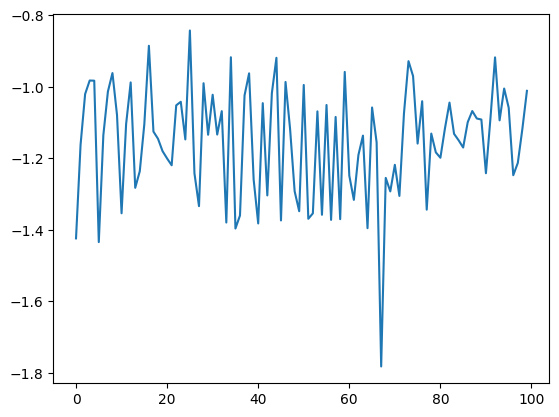

In [62]:
# evaluate the loss for many randomly sampled thetas
numruns = 100
np.random.seed(5)
manytheta0 = 1e-1*jnp.array(np.random.normal(size=numparams*numruns), dtype=np.float64).reshape((numruns, -1))

# use the many-theta version of the loss function,
# but only evaluate along one trajectory, to save memory and time
testloss = jvthetaloss(manytheta0, 0)

# plot log_{10} of the losses obtained from the random thetas
plt.plot(jnp.log(testloss)/jnp.log(10))
plt.show()

# pick the best theta
minind = jnp.argmin(testloss)
theta0 = manytheta0[minind]

In [63]:
# optimize using SciPy plus wrapped functions above (siobj & sigrad),
# starting from the initial theta0 chosen via random sampling
res = scipy.optimize.minimize( siobj, 
                               x0 = theta0,
                               method = 'trust-constr', 
                               jac = sigrad,
                               options = {'disp': True, 'verbose': 2, 'xtol': 1e-10, 'gtol': 1e-10, 'maxiter': 200} )
trainedtheta = res.x

| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  |
|-------|-------|-------|-------------|----------|----------|----------|
|   1   |   1   |   0   | +1.6523e-02 | 1.00e+00 | 3.04e-01 | 0.00e+00 |
|   2   |   2   |   1   | +1.6523e-02 | 5.00e-01 | 3.04e-01 | 0.00e+00 |
|   3   |   3   |   2   | +1.6523e-02 | 2.50e-01 | 3.04e-01 | 0.00e+00 |
|   4   |   4   |  11   | +1.6523e-02 | 1.25e-01 | 3.04e-01 | 0.00e+00 |
|   5   |   5   |  20   | +1.6523e-02 | 6.25e-02 | 3.04e-01 | 0.00e+00 |
|   6   |   6   |  23   | +1.6523e-02 | 6.25e-02 | 3.04e-01 | 0.00e+00 |
|   7   |   7   |  25   | +1.6523e-02 | 3.12e-02 | 3.04e-01 | 0.00e+00 |
|   8   |   8   |  27   | +1.6523e-02 | 1.24e-02 | 3.04e-01 | 0.00e+00 |
|   9   |   9   |  29   | +8.5683e-03 | 2.48e-02 | 3.16e-01 | 0.00e+00 |
|  10   |  10   |  32   | +8.5650e-03 | 2.48e-02 | 3.16e-01 | 0.00e+00 |
|  11   |  11   |  35   | +8.2097e-03 | 2.48e-02 | 3.81e-01 | 0.00e+00 |
|  12   |  12   |  38   | +8.1191e-03 | 2.48e-02 | 

In [64]:
# plt.plot(res.x)

In [65]:
def myinfo(ind):
    print(trnfrq[ind], trnamp[ind])

In [66]:
# with open('./thetas/memory_tdcis/120stepsmemory_2kstepspropagation_linear_model_theta.npz','wb') as f:
#     np.save(f,trainedtheta)

In [67]:
# for i in inds:
#     fig, axs = plt.subplots(2, 2, figsize=(10,8))
#     #axs[0,0].plot(mlprop[:,0,0].real, color='red')
#     axs[0,0].plot(jnp.real(trnden[i][:mynumsteps+1,0,0]),color='black')
#     axs[0,0].set_title('P'+str(0)+str(0)+' Real')

#     #axs[0,1].plot(mlprop[:,0,1].real, color='red')
#     axs[0,1].plot(jnp.real(trnden[i][:mynumsteps+1,0,1]),color='black')
#     axs[0,1].set_title('P'+str(0)+str(1)+' Real')

#     #axs[1,0].plot(mlprop[:,0,1].imag, color='red')
#     axs[1,0].plot(jnp.imag(trnden[i][:mynumsteps+1,0,1]),color='black')
#     axs[1,0].set_title('P'+str(0)+str(1)+' Imaginary')

#     #axs[1,1].plot(mlprop[:,1,1].real, color='red')
#     axs[1,1].plot(jnp.real(trnden[i][:mynumsteps+1,1,1]),color='black')
#     axs[1,1].set_title('P'+str(1)+str(1)+' Real')
#     plt.legend(['ML Prop', 'Ground Truth'])
#     #plt.show()
#     #plt.close()

In [68]:
trnden = jnp.array(np.load('./tdcis_data/tdcis_dt0.0082680.npz'))
trndentdhf = jnp.array(np.load('./tdhf_data/rt-tdhf_forcing_full_finedt.npz'))
trnfrq = jnp.array(np.load('./tdcis_data/tdcis_trnfreq_dt0.008268.npz'))
trnamp = jnp.array(np.load('./tdcis_data/tdcis_trnamp_dt0.008268.npz'))
trntme = jnp.array(np.load('./tdcis_data/tdcis_trntme_dt0.008268.npz'))

In [69]:
trnden.shape

(301, 10000, 2, 2)

In [70]:
inds

array([145])

In [75]:
i = 145
myinfo(i)
mynumsteps = 500
ic = trnden[i][0,:,:].reshape((-1))
#can try propagating ondifferent amt of steps
mlprop = MMUT_Prop_Memory(trainedtheta, ic, dt=dt, ntvec=mynumsteps, tmeoff=trntme[i], fldfrq=trnfrq[i], fldamp=trnamp[i])

0.9000000000000001 -0.5


0.017470230166902547


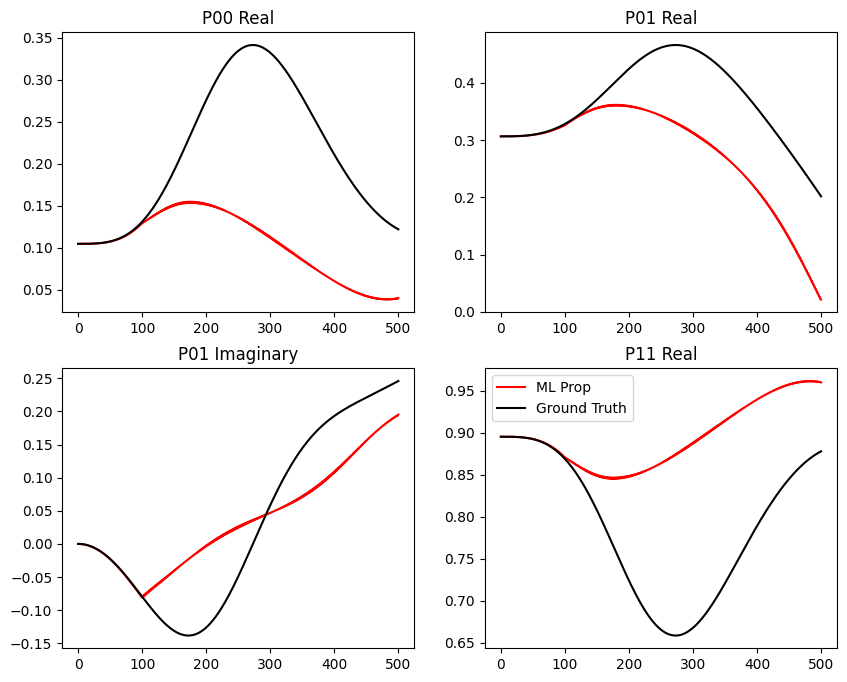

In [76]:
print(jnp.mean(jnp.abs(mlprop - trnden[i][:mynumsteps+1,:,:])**2))
fig, axs = plt.subplots(2, 2, figsize=(10,8))
axs[0,0].plot(mlprop[:,0,0].real, color='red')
axs[0,0].plot(jnp.real(trnden[i][:mynumsteps+1,0,0]),color='black')
axs[0,0].set_title('P'+str(0)+str(0)+' Real')

axs[0,1].plot(mlprop[:,0,1].real, color='red')
axs[0,1].plot(jnp.real(trnden[i][:mynumsteps+1,0,1]),color='black')
axs[0,1].set_title('P'+str(0)+str(1)+' Real')

axs[1,0].plot(mlprop[:,0,1].imag, color='red')
axs[1,0].plot(jnp.imag(trnden[i][:mynumsteps+1,0,1]),color='black')
axs[1,0].set_title('P'+str(0)+str(1)+' Imaginary')

axs[1,1].plot(mlprop[:,1,1].real, color='red')
axs[1,1].plot(jnp.real(trnden[i][:mynumsteps+1,1,1]),color='black')
axs[1,1].set_title('P'+str(1)+str(1)+' Real')
#plt.savefig('./figures/memory/polynomial_model_5stepsmemory_2kprop.pdf')
plt.legend(['ML Prop', 'Ground Truth'])
plt.show()
plt.close()

In [ ]:
# 1k steps:
# TDHF Hamiltonian true theta loss: 0.010243213034352787
# memory 1-step training loss: 0.00253650274771213
# memory 2-step training loss: 0.002497673708462945
# memory 5-step training loss: 0.0024484148373247468

# 500 steps:
# TDHF Hamiltonian true theta loss: 0.0026438892383214957
# memory 1-step training loss: 9.210085073722918e-06
# memory 2-step training loss: 9.16744614942511e-06
# memory 5-step training loss: 9.16539059978862e-06
 
# 2000 steps:
# TDHF Hamiltonian true theta loss: 0.020693919900817134
# memory 1-step training loss: 0.004882286574078557
# memory 2-step training loss: 0.004876315008180665
# memory 5-step training loss:  0.004874786252107475


In [54]:
losses500steps = [0.0026438892383214957, 9.210085073722918e-06, 9.16744614942511e-06,  9.16539059978862e-06 ]
losses1ksteps = [0.010243213034352787,  0.00253650274771213, 0.002497673708462945, 0.0024484148373247468]
losses2ksteps = [ 0.020693919900817134, 0.004882286574078557, 0.004876315008180665, 0.004874786252107475]

In [55]:
# x = [1,2,5]
# xi = list(range(len(x)))
# plt.plot(xi,losses500steps[1:]);
# plt.xticks(xi,x);
# plt.ylabel('Training Loss');
# plt.xlabel('Steps of Memory');
# plt.title('500 Propagation Steps Losses (True TDHF Theta Loss: 0.0026438892)');
# plt.savefig('./figures/500steps_memory_losses_highamp.pdf')

In [56]:
# x = [1,2,5]
# xi = list(range(len(x)))
# plt.plot(xi,losses1ksteps[1:]);
# plt.xticks(xi,x);
# plt.ylabel('Training Loss');
# plt.xlabel('Steps of Memory');
# plt.title('1000 Propagation Steps Losses (True TDHF Theta Loss:0.010243213)');
# plt.savefig('./figures/1ksteps_memory_losses_highamp.pdf')

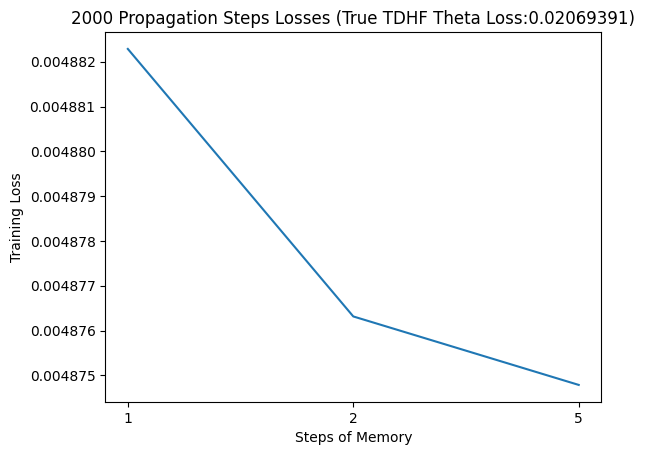

In [57]:
# x = [1,2,5]
# xi = list(range(len(x)))
# plt.plot(xi,losses2ksteps[1:]);
# plt.xticks(xi,x);
# plt.ylabel('Training Loss');
# plt.xlabel('Steps of Memory');
# plt.title('2000 Propagation Steps Losses (True TDHF Theta Loss:0.02069391)');
# plt.savefig('./figures/2ksteps_memory_losses_highamp.pdf')

In [55]:
i = 145
ic = trnden[i][0,:,:].reshape((-1))
mlprop = MMUT_Prop_Memory(trainedtheta, ic, dt=dt, ntvec=mynumsteps, tmeoff=trntme[i], fldfrq=trnfrq[i], fldamp=trnamp[i])

0.07297552750011936
0.14610325710346284


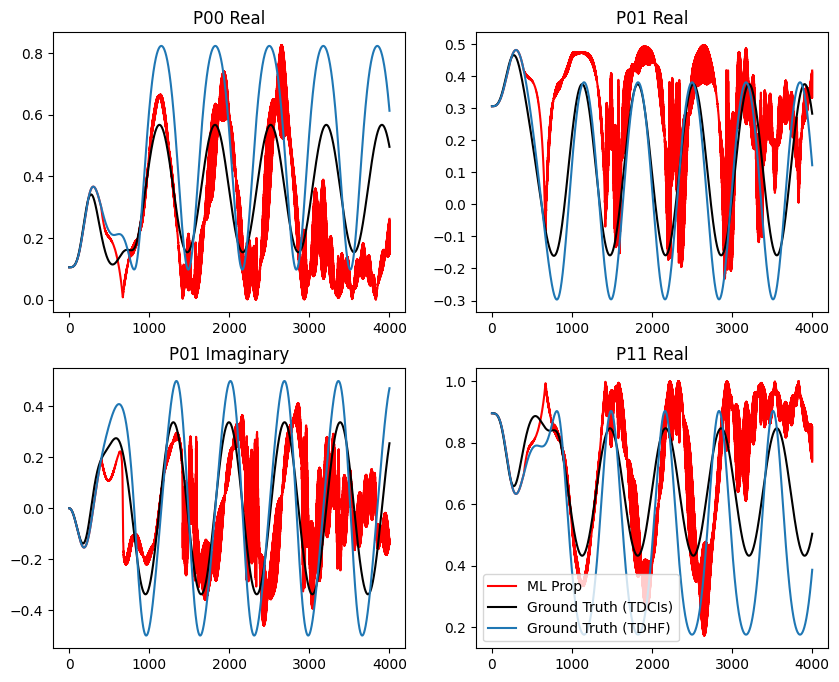

In [56]:
print(jnp.mean(jnp.abs(mlprop - trnden[i][:mynumsteps+1,:,:])**2))
print(jnp.mean(jnp.abs(mlprop - trndentdhf[i][:mynumsteps+1,:,:])**2))
fig, axs = plt.subplots(2, 2, figsize=(10,8))
axs[0,0].plot(mlprop[:,0,0].real, color='red')
axs[0,0].plot(jnp.real(trnden[i][:mynumsteps+1,0,0]),color='black')
axs[0,0].plot(jnp.real(trndentdhf[i][:mynumsteps+1,0,0]))
axs[0,0].set_title('P'+str(0)+str(0)+' Real')

axs[0,1].plot(mlprop[:,0,1].real, color='red')
axs[0,1].plot(jnp.real(trnden[i][:mynumsteps+1,0,1]),color='black')
axs[0,1].plot(jnp.real(trndentdhf[i][:mynumsteps+1,0,1]))
axs[0,1].set_title('P'+str(0)+str(1)+' Real')

axs[1,0].plot(mlprop[:,0,1].imag, color='red')
axs[1,0].plot(jnp.imag(trnden[i][:mynumsteps+1,0,1]),color='black')
axs[1,0].plot(jnp.imag(trndentdhf[i][:mynumsteps+1,0,1]))
axs[1,0].set_title('P'+str(0)+str(1)+' Imaginary')

axs[1,1].plot(mlprop[:,1,1].real, color='red')
axs[1,1].plot(jnp.real(trnden[i][:mynumsteps+1,1,1]),color='black')
axs[1,1].plot(jnp.real(trndentdhf[i][:mynumsteps+1,1,1]))
axs[1,1].set_title('P'+str(1)+str(1)+' Real')

plt.legend(['ML Prop', 'Ground Truth (TDCIs)', 'Ground Truth (TDHF)'])
#plt.legend(['Ground Truth (TDCIs)', 'Ground Truth (TDHF)'])
plt.show()
plt.close()

In [67]:
# # pick one training trajectory, and for this trajectory, 
# # plot the MSE at each point in time between
# # (1) mlprop, the result we get by propagating using the learned theta from optimization --- "res.x",
# # (2) the ground truth training trajectory
# for ii in range(140,160):
#     i = ii
#     ic = trnden[i][0,:,:].reshape((-1))
#     mlprop = MMUT_Prop_HSB(jnp.array(res.x), 
#                            ic, dt=dt, ntvec=mynumsteps, tmeoff=trntme[i], fldfrq=trnfrq[i], fldamp=trnamp[i])
#     #print(mlprop.shape)
#     #print(trnden[i][:mynumsteps+1,:,:].shape)
#     print(trnfrq[i],trnamp[i])
#     print(jnp.mean(jnp.abs(mlprop - trnden[i][:mynumsteps+1,:,:])**2))
#     print('=============================================')
#     plt.figure(figsize=(6,4))
#     plt.plot(jnp.mean(jnp.abs(mlprop-trnden[i][:mynumsteps+1,:,:])**2,axis=(1,2)))
# plt.show()

In [48]:
# compute and return all the densities **and** all the Hamiltonians along one trajectory!
def MMUT_Save_Ham(theta, initial_density, dt=0.08268, ntvec=2000,
                  tmeoff=1, fldfrq=1, fldamp=1, norm_direc=jnp.array([0.0,0.0,1.0])):
    tvec = dt*jnp.arange(ntvec)
    P0 = initial_density.reshape((drc, drc))
    propagated_dens = [P0]
    H0 = MLham(theta,0.0,P0.real, P0.imag,fldfrq,fldamp,tmeoff,norm_direc)
    H0 = H0[0] + 1.0j*H0[1]
    propagated_hams = [H0]
    evals, evecs = jnp.linalg.eigh(H0)
    U0 = evecs @ jnp.diag(jnp.exp(-1j*dt*evals)) @ evecs.conj().T
    P1 = U0 @ P0 @ U0.conj().T
    propagated_dens.append( P1 )
    def bodyfun(i, intup):
        dl, hl = intup
        P0 = dl[i, :, :]
        P1 = dl[i+1, :, :]
        H1 = MLham(theta,(i+1.0)*dt,P1.real, P1.imag,fldfrq,fldamp,tmeoff,norm_direc)
        H1 = H1[0] + 1.0j*H1[1]
        evals, evecs = jnp.linalg.eigh(H1)
        U1 = evecs @ jnp.diag(jnp.exp(-2j*dt*evals)) @ evecs.conj().T
        P2 = U1 @ P0 @ U1.conj().T
        return (dl.at[i+2].set( P2 ), hl.at[i+1].set( H1 ))
    
    alldens = jnp.concatenate([jnp.stack(propagated_dens), jnp.zeros((ntvec-1, drc, drc))], axis=0)
    allhams = jnp.concatenate([jnp.stack(propagated_hams), jnp.zeros((ntvec-1, drc, drc))], axis=0)
    fdh = lax.fori_loop(0, ntvec-1, bodyfun, (alldens, allhams))
    
    return fdh

In [49]:
# compute mean square commutator errors for one trajectory
def commutatorerror(theta, i):
    ic = trnden[i][0,:,:].reshape((-1))
    mynumsteps = 4000
    mydenham = MMUT_Save_Ham(theta, ic, dt=dt, ntvec=mynumsteps, tmeoff=trntme[i], fldfrq=trnfrq[i], fldamp=trnamp[i])
    trdenham = MMUT_Save_Ham(thetatrue, ic, dt=dt, ntvec=mynumsteps, tmeoff=trntme[i], fldfrq=trnfrq[i], fldamp=trnamp[i])

    mycom = jnp.einsum('aij,ajk->aik',mydenham[1],mydenham[0][:-1,:,:]) - jnp.einsum('aij,ajk->aik',mydenham[0][:-1,:,:],mydenham[1])
    trcom = jnp.einsum('aij,ajk->aik',trdenham[1],trdenham[0][:-1,:,:]) - jnp.einsum('aij,ajk->aik',trdenham[0][:-1,:,:],trdenham[1])

    return jnp.mean(jnp.square(jnp.abs(mycom - trcom)))

In [50]:
# many trajectory version
vcommutatorerror = vmap(commutatorerror, (None, 0))
jvcommutatorerror = jit(vcommutatorerror)

In [51]:
# evaluate commutator errors on training set
allcommerrs = jvcommutatorerror(jnp.array(res.x), jnp.arange(100))

InconclusiveDimensionOperation: Cannot divide evenly the sizes of shapes (8,) and (4, 4)

In [ ]:
# min, mean, and max commutator error
print(jnp.min(allcommerrs), jnp.mean(allcommerrs), jnp.max(allcommerrs))